<a href="https://colab.research.google.com/github/drizzletechnova/projects/blob/main/image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
import torchvision.datasets as datasets
from torchvision import transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
path = 'model_data/'
train_data =  datasets.CIFAR10(path,train=True,download=True)
val_data =  datasets.CIFAR10(path,train=False,download=True)

100%|██████████| 170M/170M [00:02<00:00, 74.2MB/s]


In [4]:
path = 'model_data/'
train_data_t =  datasets.CIFAR10(path,train=True,download=True,transform=transforms.ToTensor())
val_data_t =  datasets.CIFAR10(path,train=False,download=True,transform=transforms.ToTensor())

In [5]:
train = DataLoader(train_data_t,shuffle=True,batch_size=64,num_workers=2)
val = DataLoader(val_data_t,shuffle=True,batch_size=64,num_workers=2)

In [6]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [7]:
len(train_data)

50000

In [8]:
img, label = train_data[99]
img, label

(<PIL.Image.Image image mode=RGB size=32x32>, 1)

In [9]:
class_names[label]

'automobile'

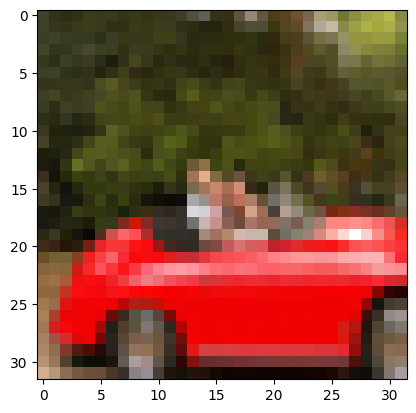

In [10]:
plt.imshow(img)

In [11]:
def get_mean_std(loader):
    mean = 0.0
    std = 0.0
    num_samples = 0
    for images, _ in loader:
        batch_size = images.size(0)
        images = images.view(batch_size,images.size(1),-1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        num_samples += batch_size
    mean /= num_samples
    std /= num_samples
    return mean,std

In [12]:
mean,std = get_mean_std(train)
final_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

In [13]:
mean,std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2023, 0.1994, 0.2010]))

In [14]:
path = 'model_data/'
train_data =  datasets.CIFAR10(path,
                               train=True,
                               download=True,
                              transform= final_transform)
val_data =  datasets.CIFAR10(path,
                               train=False,
                               download=True,
                              transform= final_transform)


In [15]:
train_data, val_data

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: model_data/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2023, 0.1994, 0.2010]))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: model_data/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2023, 0.1994, 0.2010]))
            ))

In [16]:
label_map = {
    0 : 0,
    2 : 1
}
label_bird_plane =  ['airplane','bird']
bird_plane_train = [(img,label_map[label]) for img,label in train_data if label in [0,2]]
bird_plane_val = [(img,label_map[label]) for img,label in val_data if label in [0,2]]

In [17]:
import torch.nn as nn
n_out = 2
model = nn.Sequential(
    nn.Linear(3072,512),
    nn.ReLU(),
    nn.Linear(512,n_out),
    nn.LogSoftmax(dim=1),
)
model.to(device)

Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=2, bias=True)
  (3): LogSoftmax(dim=1)
)

In [18]:
bird_plane_train_loader = DataLoader(bird_plane_train,batch_size = 64, shuffle=True,pin_memory=True,num_workers=2)
bird_plane_val_loader = DataLoader(bird_plane_val,batch_size = 64, shuffle=True,pin_memory=True,num_workers=2)

In [19]:
loss_fn = nn.NLLLoss()
lr = 1e-2
optimizer =  optim.SGD(model.parameters(),lr=lr)
epochs = 100

In [20]:
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # === TRAINING ===
    model.train()
    total_train_loss = 0
    num_batches = 0

    for imgs, labels in bird_plane_train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        preds = model(imgs.view(imgs.size(0), -1))
        loss = loss_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        num_batches += 1

    avg_train_loss = total_train_loss / num_batches
    train_losses.append(avg_train_loss)

    # === VALIDATION ===
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.inference_mode():
        for imgs, labels in bird_plane_val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            preds = model(imgs.view(imgs.size(0), -1))  # same note about .view
            loss = loss_fn(preds, labels)
            val_loss += loss.item()

            predicted = preds.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(bird_plane_val_loader)
    accuracy = correct / total

    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {accuracy*100:.2f}%")

Epoch 01 | Train Loss: 0.4827 | Val Loss: 0.4364 | Val Acc: 80.90%
Epoch 02 | Train Loss: 0.4171 | Val Loss: 0.4198 | Val Acc: 82.65%
Epoch 03 | Train Loss: 0.3882 | Val Loss: 0.4015 | Val Acc: 82.05%
Epoch 04 | Train Loss: 0.3664 | Val Loss: 0.4695 | Val Acc: 77.95%
Epoch 05 | Train Loss: 0.3461 | Val Loss: 0.3785 | Val Acc: 84.30%
Epoch 06 | Train Loss: 0.3294 | Val Loss: 0.4089 | Val Acc: 83.25%
Epoch 07 | Train Loss: 0.3128 | Val Loss: 0.4020 | Val Acc: 82.75%
Epoch 08 | Train Loss: 0.2973 | Val Loss: 0.3637 | Val Acc: 85.00%
Epoch 09 | Train Loss: 0.2808 | Val Loss: 0.3949 | Val Acc: 85.00%
Epoch 10 | Train Loss: 0.2722 | Val Loss: 0.4334 | Val Acc: 83.00%
Epoch 11 | Train Loss: 0.2571 | Val Loss: 0.3793 | Val Acc: 83.85%
Epoch 12 | Train Loss: 0.2449 | Val Loss: 0.3686 | Val Acc: 84.35%
Epoch 13 | Train Loss: 0.2366 | Val Loss: 0.3893 | Val Acc: 83.05%
Epoch 14 | Train Loss: 0.2296 | Val Loss: 0.3484 | Val Acc: 85.70%
Epoch 15 | Train Loss: 0.2093 | Val Loss: 0.3643 | Val Acc: 84

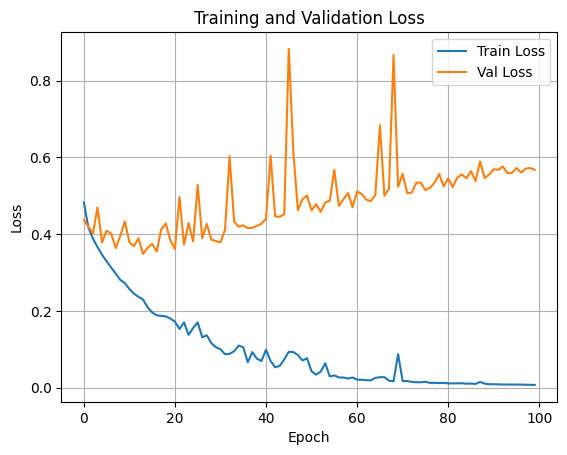

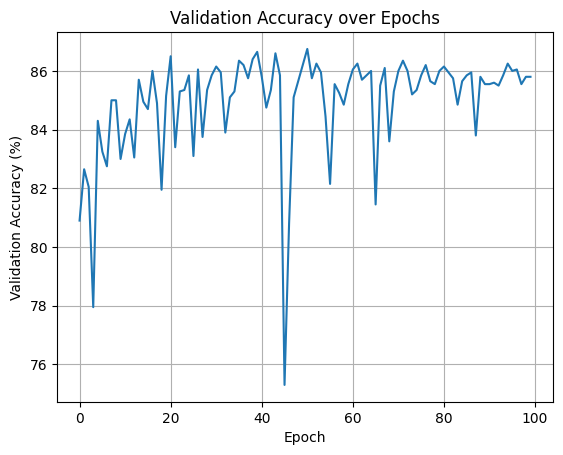

In [21]:
import matplotlib.pyplot as plt

# Loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.plot([acc * 100 for acc in val_accuracies])
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy over Epochs")
plt.grid(True)
plt.show()
plt.tight_layout()

In [22]:
image_classifier = nn.Sequential(
    nn.Linear(3072,1024),
    nn.ReLU(),
    #nn.Tanh(),
    nn.Linear(1024,512),
    nn.ReLU(),
   # nn.Tanh(),
    nn.Linear(512,128),
    nn.ReLU(),
    #nn.Tanh(),
    nn.Linear(128,10),
    nn.LogSoftmax(dim=1)
)
image_classifier.to(device)

Sequential(
  (0): Linear(in_features=3072, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)

In [23]:
train_loader = DataLoader(train_data,batch_size = 64, shuffle=True,pin_memory=True,num_workers=2)
val_loader = DataLoader(val_data,batch_size = 64, shuffle=True,pin_memory=True,num_workers=2)

In [24]:
#!watch -n 1 nvidia-smi

In [25]:
lr = 1e-2
cost_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(image_classifier.parameters(),lr = lr)
epochs =  100

In [26]:
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # === TRAINING ===
    image_classifier.train()
    total_train_loss = 0
    num_batches = 0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        preds = image_classifier(imgs.view(imgs.size(0), -1))
        loss = cost_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        num_batches += 1

    avg_train_loss = total_train_loss / num_batches
    train_losses.append(avg_train_loss)

    # === VALIDATION ===
    image_classifier.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.inference_mode():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            preds = image_classifier(imgs.view(imgs.size(0), -1))  # same note about .view
            loss = cost_fn(preds, labels)
            val_loss += loss.item()

            predicted = preds.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct / total

    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {accuracy*100:.2f}%")

Epoch 01 | Train Loss: 1.9866 | Val Loss: 1.7558 | Val Acc: 37.72%
Epoch 02 | Train Loss: 1.6611 | Val Loss: 1.5818 | Val Acc: 44.62%
Epoch 03 | Train Loss: 1.5248 | Val Loss: 1.5027 | Val Acc: 47.26%
Epoch 04 | Train Loss: 1.4270 | Val Loss: 1.4663 | Val Acc: 47.89%
Epoch 05 | Train Loss: 1.3503 | Val Loss: 1.4458 | Val Acc: 49.16%
Epoch 06 | Train Loss: 1.2814 | Val Loss: 1.4612 | Val Acc: 48.88%
Epoch 07 | Train Loss: 1.2215 | Val Loss: 1.3813 | Val Acc: 51.88%
Epoch 08 | Train Loss: 1.1640 | Val Loss: 1.3706 | Val Acc: 52.05%
Epoch 09 | Train Loss: 1.1077 | Val Loss: 1.3826 | Val Acc: 52.28%
Epoch 10 | Train Loss: 1.0586 | Val Loss: 1.4673 | Val Acc: 50.20%
Epoch 11 | Train Loss: 1.0097 | Val Loss: 1.4549 | Val Acc: 52.16%
Epoch 12 | Train Loss: 0.9604 | Val Loss: 1.4968 | Val Acc: 49.97%
Epoch 13 | Train Loss: 0.9120 | Val Loss: 1.4146 | Val Acc: 52.92%
Epoch 14 | Train Loss: 0.8637 | Val Loss: 1.4737 | Val Acc: 52.45%
Epoch 15 | Train Loss: 0.8154 | Val Loss: 1.5727 | Val Acc: 50

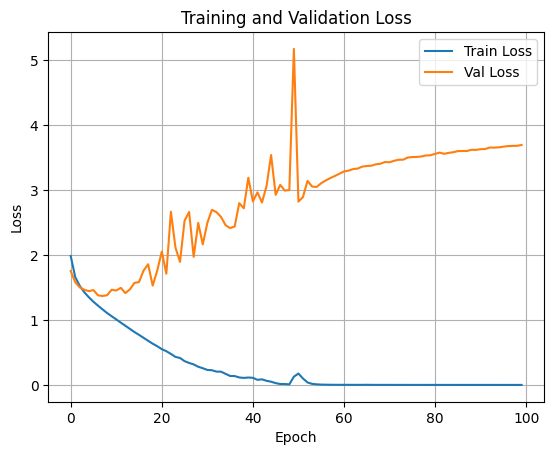

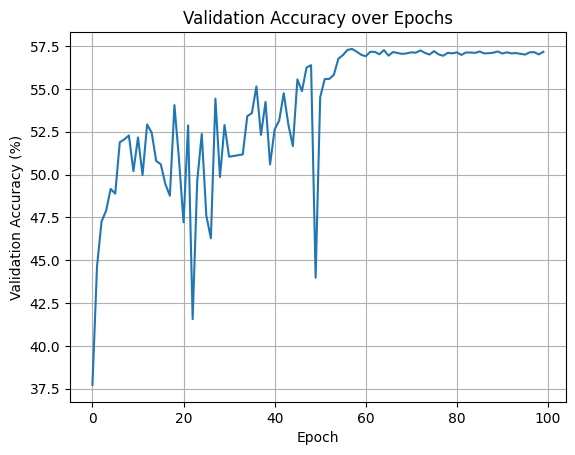

In [27]:
import matplotlib.pyplot as plt

# Loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.plot([acc * 100 for acc in val_accuracies])
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy over Epochs")
plt.grid(True)
plt.show()